In this post, we investigate the static electric field defined by a set of discrete particles. We go on to try and reproduce a famous graph originally published by James Maxwell, the famous 19th century physicist, using `matplotlib`.

If you're wondering what got me started on this topic, it's this tweet:

<blockquote class="twitter-tweet" data-lang="fr"><p lang="en" dir="ltr">Ok, I got a pretty good port of these Maxwell equation figures into Python. Heavy use of JAX and <a href="https://twitter.com/matplotlib?ref_src=twsrc%5Etfw">@matplotlib</a>. I&#39;ll tidy up the code post it here later. <a href="https://t.co/Bs7GILVEgN">https://t.co/Bs7GILVEgN</a> <a href="https://t.co/qXcGOkibL5">pic.twitter.com/qXcGOkibL5</a></p>&mdash; Colin Carroll (@colindcarroll) <a href="https://twitter.com/colindcarroll/status/1218913836562075648?ref_src=twsrc%5Etfw">19 janvier 2020</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>


# Background: the static electric field, forces and potential 

The static electric force created by a single fixed charge $q_1$ on another one $q_2$  is a vector force (Coulomb's law) usually written as:

$$
\vec{F}=\frac{1}{4\pi\varepsilon_0}\,\frac{q_1q_2}{r_{12}^2}\,\vec{e}_{12}
$$

(with the vector $\vec{e}_{12}$ pointing from 2 to 1)

This lets us define a field which is related to the above force by the relationship

$$
\vec{F} = q_1 \vec{E}
$$

Intuitively, it can be explained like so:

> An electric field is a vector field that associates to each point in space the Coulomb force experienced by a test charge [if it were positioned at that point]

(found in the Wikipedia article about [Coulomb's law](https://en.wikipedia.org/wiki/Coulomb%27s_law))

From the first formula, it follows that the field can be computed from a single charge's location with

$$
\vec{E}=\frac{1}{4\pi\varepsilon_0}\,\frac{q_2}{r_{12}^2}\,\vec{e}_{12}
$$

And if you have multiple charges, you just sum over these to get the total field:

$$
\vec{E}_{total}=\sum_i \frac{1}{4\pi\varepsilon_0}\,\frac{q_i}{r_{i}^2}\,\vec{e}_{i}
$$


In practice, once you know this formula, you can solve all of your electrostatic problems. To quote [Feynman's lecture on the topic](https://www.feynmanlectures.caltech.edu/II_04.html), which is well worth reading:

> Given the charges, what are the fields? Answer: Do this integral. So there is nothing to the subject; it is just a case of doing complicated integrals over three dimensions—strictly a job for a computing machine! 

(admittedly, he's talking about the integral form and not the discrete charge formula I've used...)

A useful feature in some case, the static electric field can also be described by a potential, written $V$. The potential is a scalar field defined as a function of space, such that

$$
\vec{E} = - \vec{\nabla} V
$$

A practical application of this potential is that once known, you can easily compute work done by charged particles following paths in electric field.

For a discrete system of particles, the potential is then written as:

$$
V_{total}=\sum_i \frac{1}{4\pi\varepsilon_0}\,\frac{q_i}{r_{i}}
$$

Regarding the upcoming visualisation, we're going to do two things:

- draw field lines
- draw isosurfaces of the potential

Field lines are lines that are drawn in the direction of the field. They are obtained by just "swimming" with the field from a given starting point.

Isosurfaces are surfaces along which the potential is constant.

# Implementation using Python 

Let's first define a charged particle class that allows us to compute the field and the potential.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

class ChargedParticle:
    def __init__(self, pos, charge):
        self.pos = np.asarray(pos)
        self.charge = charge
        
    def compute_field(self, x, y):
        X, Y = np.meshgrid(x, y)
        u_i = np.hstack((X.ravel()[:, np.newaxis],  Y.ravel()[:, np.newaxis])) - self.pos
        r = np.sqrt((X - self.pos[0])**2 + (Y - self.pos[1])**2)
        field = ((self.charge / r**2).ravel()[:, np.newaxis] * u_i).reshape(X.shape + (2,))
        return field
    
    def compute_potential(self, x, y):
        X, Y = np.meshgrid(x, y)
        r = np.sqrt((X - self.pos[0])**2 + (Y - self.pos[1])**2)
        potential = self.charge / r
        return potential

We can test it by creating two particles with opposite charge.

In [2]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-4, 4, 80)

Y, X = np.meshgrid(x, y)

q1 = ChargedParticle((-1, 0), -1)
q2 = ChargedParticle((1, 0), 1)

Let's plot their fields:

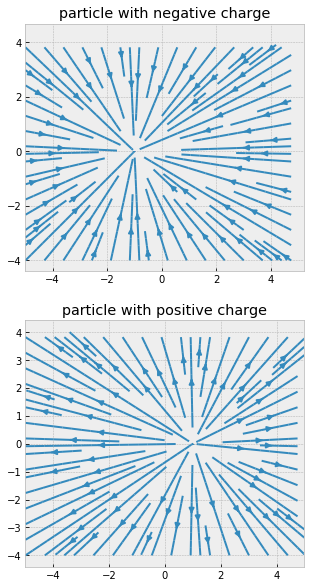

In [3]:
field1 = q1.compute_field(x, y)
field2 = q2.compute_field(x, y)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(5, 10))
ax1.streamplot(x, y, u=field1[:, :, 0], v=field1[:, :, 1])
ax1.set_title("particle with negative charge");
ax1.axis('equal')
ax2.streamplot(x, y, u=field2[:, :, 0], v=field2[:, :, 1])
ax2.set_title("particle with positive charge");
ax2.axis('equal');

As expected, field lines are converging towards the negative charge and diverging from the posive charge.

What about the potential?

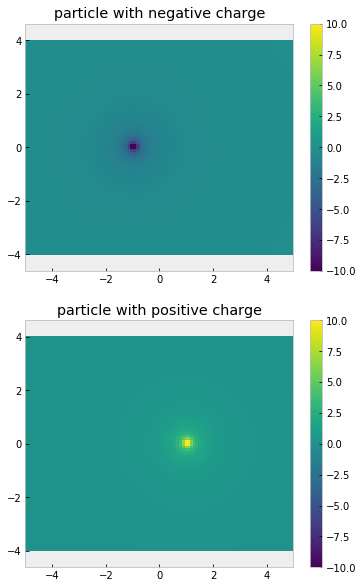

In [4]:
pot1 = q1.compute_potential(x, y)
pot2 = q2.compute_potential(x, y)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 10))
map1 = ax1.pcolormesh(x, y, pot1, vmin=-10, vmax=10)
ax1.set_title("particle with negative charge");
ax1.axis('equal')
plt.colorbar(map1, ax=ax1)
map2 = ax2.pcolormesh(x, y, pot2, vmin=-10, vmax=10)
ax2.set_title("particle with positive charge");
ax2.axis('equal');
plt.colorbar(map2, ax=ax2);

We can now compute the whole field by summing over the individual electric fields.

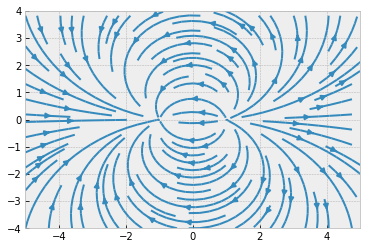

In [5]:
def compute_resulting_field(particles, x, y):
    fields = [p.compute_field(x, y) for p in particles]
    total_field = np.zeros_like(fields[0])
    for field in fields:
        total_field += field
    return total_field

total_field = compute_resulting_field([q1, q2], x, y)

plt.streamplot(x, y, total_field[:, :, 0], total_field[:, :, 1])
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max());

We can even explore some options regarding the streamplot.

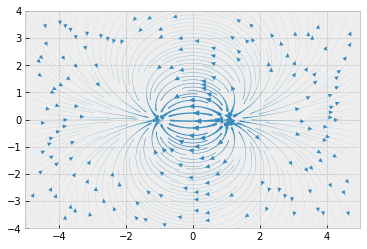

In [6]:
lw = np.linalg.norm(total_field, axis=2)
lw /= lw.max()
plt.streamplot(x, y, total_field[:, :, 0], total_field[:, :, 1], linewidth=10*lw, density=2)
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max());

What about the potential?

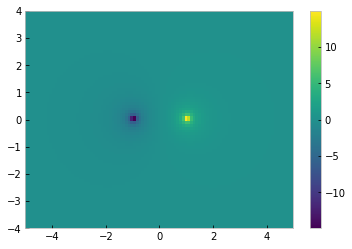

In [7]:
def compute_resulting_potential(particles, x, y):
    potentials = [p.compute_potential(x, y) for p in particles]
    total_potential = np.zeros_like(potentials[0])
    for pot in potentials:
        total_potential += pot
    return total_potential

total_potential = compute_resulting_potential([q1, q2], x, y)
plt.pcolormesh(x, y, total_potential)
plt.colorbar();

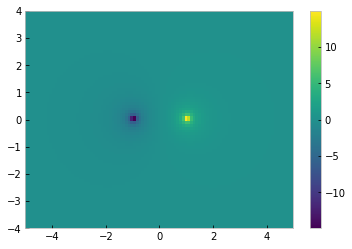

In [8]:
total_potential = compute_resulting_potential([q1, q2], x, y)
plt.pcolormesh(x, y, total_potential)
plt.colorbar();

# Case studies 

## Four charges on a square

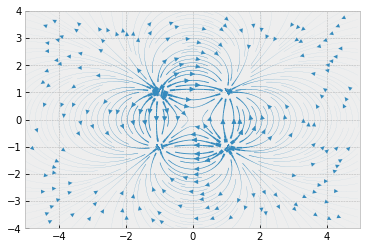

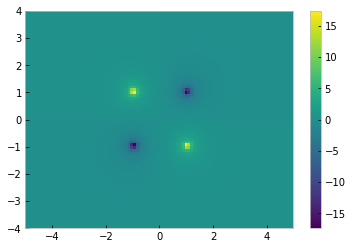

In [9]:
q1 = ChargedParticle((1, 1), -1)
q2 = ChargedParticle((-1, 1), 1)
q3 = ChargedParticle((-1, -1), -1)
q4 = ChargedParticle((1, -1), 1)
total_field = compute_resulting_field([q1, q2, q3, q4], x, y)
total_potential = compute_resulting_potential([q1, q2, q3, q4], x, y)

lw = np.linalg.norm(total_field, axis=2)
lw /= lw.max()
fig, ax = plt.subplots()
ax.streamplot(x, y, total_field[:, :, 0], total_field[:, :, 1], linewidth=10*lw, density=2)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())

fig, ax = plt.subplots()
mappable = ax.pcolormesh(x, y, total_potential)
plt.colorbar(mappable);

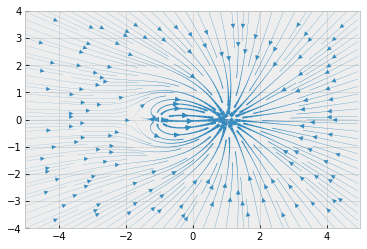

In [10]:
q1 = ChargedParticle((1, 0), -4)
q2 = ChargedParticle((-1, 0), 1)
total_field = compute_resulting_field([q1, q2], x, y)
lw = np.linalg.norm(total_field, axis=2)
lw /= lw.max()
plt.streamplot(x, y, total_field[:, :, 0], total_field[:, :, 1], linewidth=20*lw, density=2)
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max());

Clearly, this is an onion shape!

# Reproducing Maxwell's plot 

Even though the initially quoted tweet got me started down the present rabbit hole, there was an earlier tweet by matplotlib asking 

<blockquote class="twitter-tweet" data-lang="fr"><p lang="en" dir="ltr">What if James Maxwell used Python and <a href="https://twitter.com/matplotlib?ref_src=twsrc%5Etfw">@matplotlib</a>? <br><br>E se Maxwell usasse Python e Matplotlib? <a href="https://t.co/XSrF5SEarG">https://t.co/XSrF5SEarG</a></p>&mdash; Céu Profundo (@CeuProfundo) <a href="https://twitter.com/CeuProfundo/status/1218690071517376512?ref_src=twsrc%5Etfw">19 janvier 2020</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>


Let's try and answer this question. First, we recreate the configuration and the $x$ and $y$ region for this plot (inspired by the source code posted by Colin Carroll).

The total field with its field lines looks like:

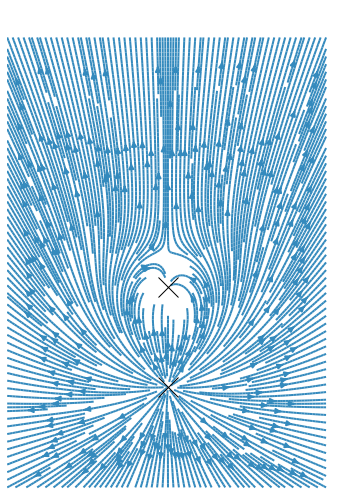

In [11]:
x = np.linspace(-1.6, 1.6, 100)
y = np.linspace(-1, 3.5, 200)
q1 = ChargedParticle((0, 0), 20)
q2 = ChargedParticle((0, 1), -5) 
total_field = compute_resulting_field([q1, q2], x, y)
lw = np.linalg.norm(total_field, axis=2)
lw /= lw.max()
fig = plt.figure(figsize=(6, 9))
plt.plot(*q1.pos, 'kx', ms=20)
plt.plot(*q2.pos, 'kx', ms=20)
plt.streamplot(x, y, total_field[:, :, 0], total_field[:, :, 1], density=4, cmap='magma', integration_direction='backward')
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plt.axis('equal')
plt.axis('off');

And the potential:

min: -2.43e+02, max: 1.18e+03


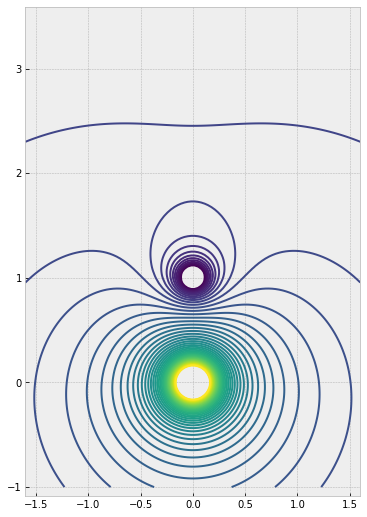

In [12]:
potential = compute_resulting_potential([q1, q2], x, y)

print(f"min: {potential.min():.2e}, max: {potential.max():.2e}")

FACTOR = 1e-1
levels = np.linspace(potential.min() * FACTOR, 
                     potential.max() * FACTOR, 
                     50)

fig = plt.figure(figsize=(6, 9))
plt.contour(x, y, potential, levels)
plt.axis('equal');

What about both together?

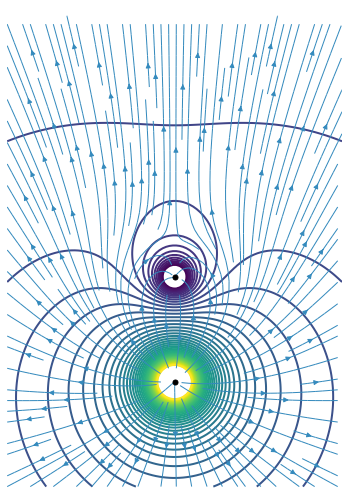

In [13]:
fig, ax = plt.subplots(figsize=(6, 9))
ax.contour(x, y, potential, levels)
ax.plot(*q1.pos, 'k.', ms=10)
ax.plot(*q2.pos, 'k.', ms=10)
ax.streamplot(x, y, total_field[:, :, 0], total_field[:, :, 1], density=1.5, linewidth=1, )
ax.axis('equal')
ax.axis('off');

At this point, we could stop and say that we have reached our goal. However, we can a little further by further playing with the aesthetics. 

To go interactive, we use ipywidgets and annotate our plotting function.

In [14]:
from ipywidgets import interact

@interact
def make_plot(FACTOR=(0.001, 10e-2, 0.001),
              n_levels=(1, 50, 1),
              density=(0.1, 5, 0.01),
              lw=(0.1, 3, 0.1),
              clabel=False):
    fig, ax = plt.subplots(figsize=(6, 9))
    levels = np.linspace(potential.min() * FACTOR, 
                         potential.max() * FACTOR, 
                         n_levels)

    CS = ax.contour(x, y, potential, levels)
    if clabel:
        ax.clabel(CS, inline=1, fontsize=10)
    ax.plot(*q1.pos, 'k.', ms=10)
    ax.plot(*q2.pos, 'k.', ms=10)
    ax.streamplot(x, y, total_field[:, :, 0], 
                  total_field[:, :, 1], 
                  density=density, linewidth=lw)
    ax.axis('equal')
    ax.axis('off')

interactive(children=(FloatSlider(value=0.05, description='FACTOR', max=0.1, min=0.001, step=0.001), IntSlider…

By playing with it, I ended up with the following nice settings:

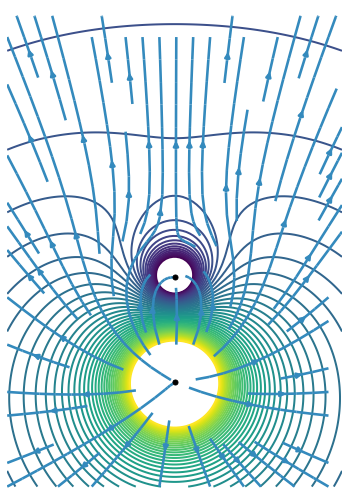

In [15]:
make_plot(**{'FACTOR': 0.036, 'n_levels': 50, 'density': 0.73, 'lw': 2.6})

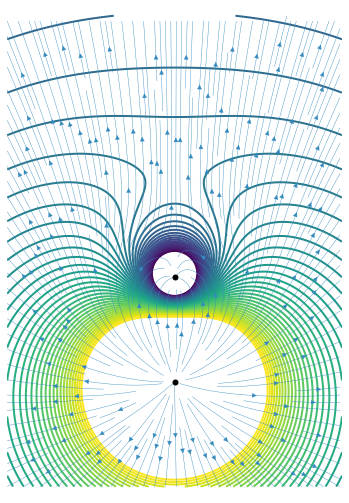

In [16]:
make_plot(**{'FACTOR': 0.016, 'n_levels': 49, 'density': 2.11, 'lw': 0.4})

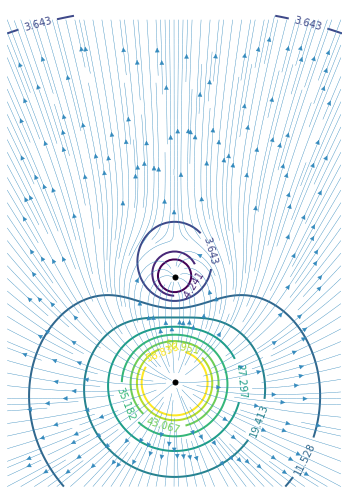

In [17]:
make_plot(**{'FACTOR': 0.05,
 'n_levels': 10,
 'density': 2.5500000000000003,
 'lw': 0.4,
 'clabel': True})

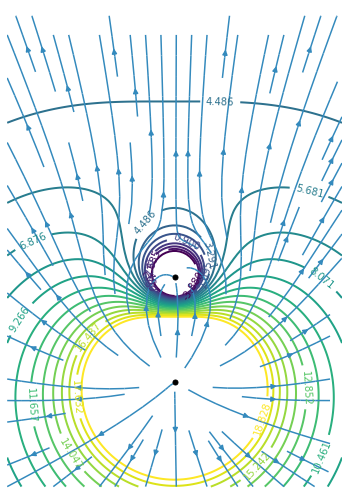

In [18]:
make_plot(**{'FACTOR': 0.016, 'n_levels': 20, 'density': 0.77, 'lw': 1.5, 'clabel': True})

If James Maxwell had had access to `matplotlib`, maybe he would have annotated the isosurfaces of his electric potential? ;)

# Conclusions 

I hope you liked my recreation of the original plot by Maxwell. I didn't try to make it look like the original since Colin Carroll already beat me to it. That's why I explored different stylings instead.

In the course of this I found a link to a simple magnetic field example in matplotlib which I found great https://scipython.com/blog/visualizing-the-earths-magnetic-field/
You'll notice how the static magnetic fieldline plot is quite different from the static electric field. Check it out if you're interested.

*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20200121_MaxwellElectrostaticField.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20200121_MaxwellElectrostaticField.ipynb).*